In [ ]:
pip install alibi[tensorflow]

In [ ]:
import tensorflow as tf
#tf.get_logger().setLevel(40) # suppress deprecation messages
#tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import Counterfactual
#print('TF version: ', tf.__version__)
#print('Eager execution enabled: ', tf.executing_eagerly()) # False

## Load and prepare MNIST data

In [ ]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_prefix = '/content/drive/My Drive/Courses/DL BU/kaggle_cem/kaggle/'

In [ ]:
# Load your data
x_train = np.load(path_prefix + 'train_data_kaggle.npy')
y_train = np.load(path_prefix + 'train_labels_kaggle.npy')
x_test = np.load(path_prefix + 'test_data_kaggle.npy')
y_test = np.load(path_prefix + 'test_labels_kaggle.npy')

x_train shape: (8192, 152, 152, 3) y_train shape: (8192, 4)


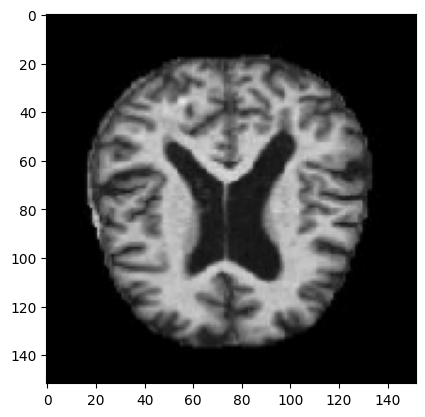

In [ ]:
# Check shapes
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)

# Visualize one example
plt.gray()
plt.imshow(x_test[2])
plt.show()

Prepare data: scale, reshape and categorize

In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (8192, 152, 152, 3, 1) x_test shape: (2560, 152, 152, 3, 1)
y_train shape: (8192, 4) y_test shape: (2560, 4)


In [ ]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

## Define and train CNN model

In [ ]:
cnn = load_model('/content/drive/My Drive/Courses/DL BU/kaggle_cem/kaggle_model.h5')

Evaluate the model on test set

In [ ]:
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Test accuracy:  0.88623046875


## Generate counterfactuals

Original instance:

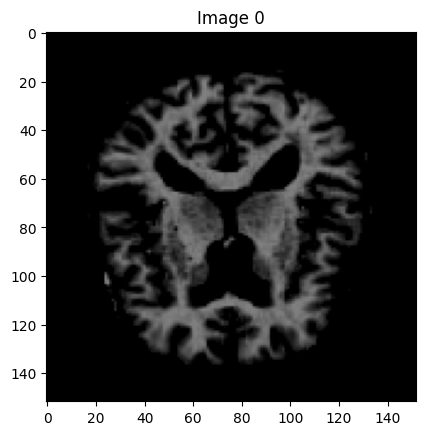

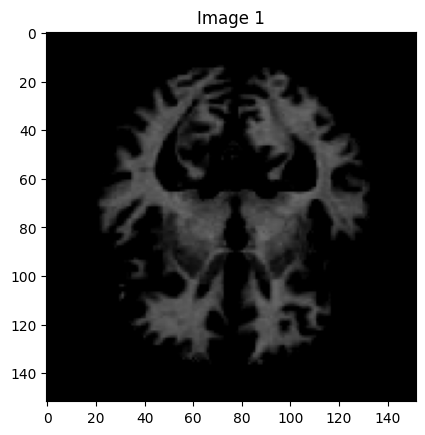

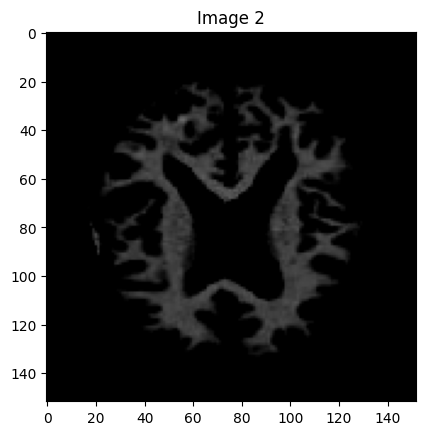

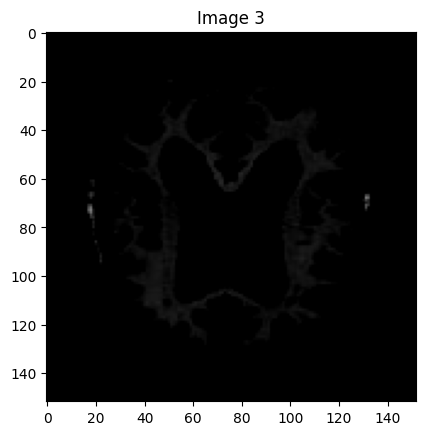

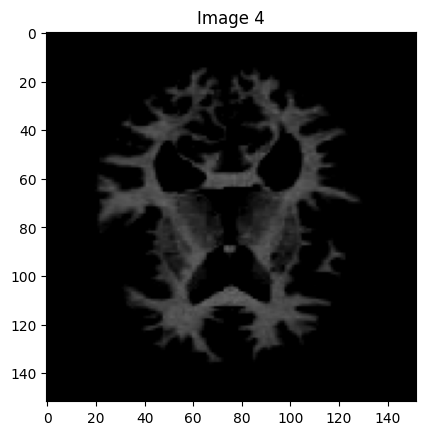

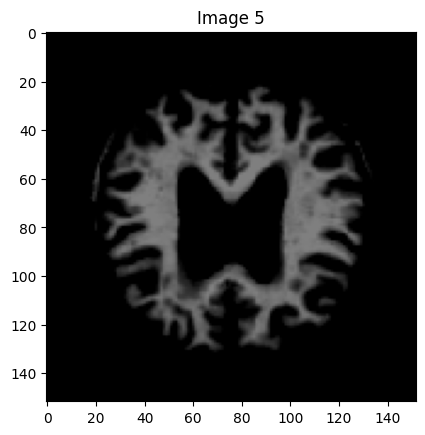

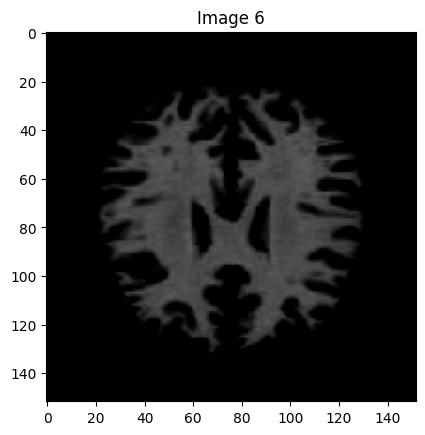

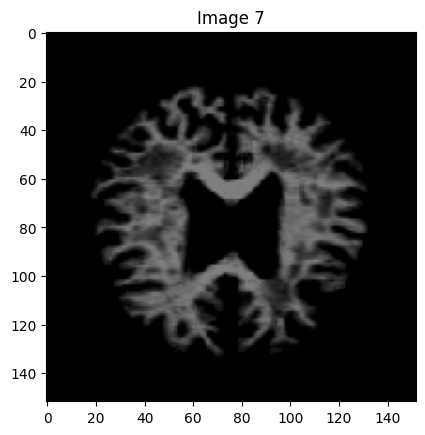

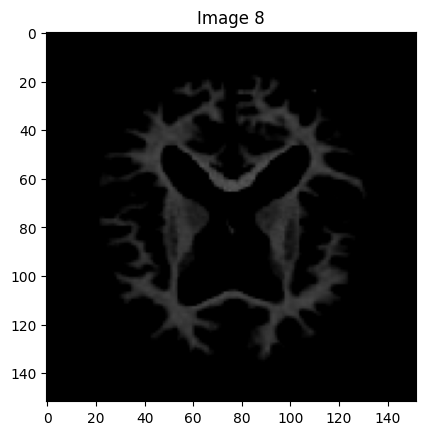

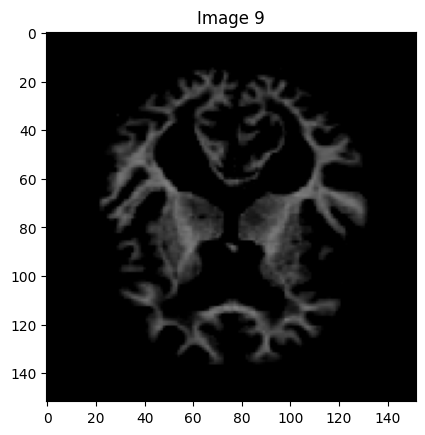

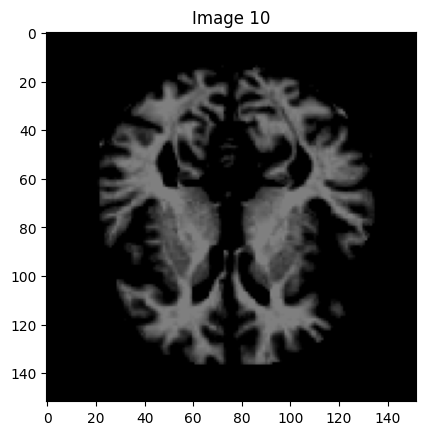

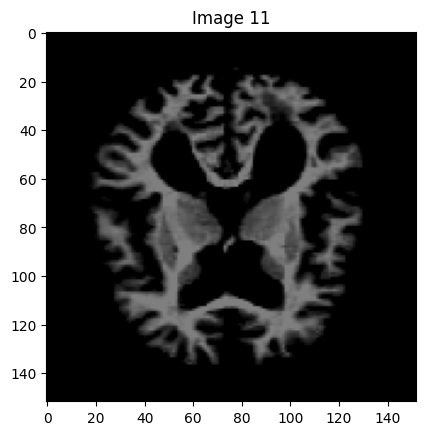

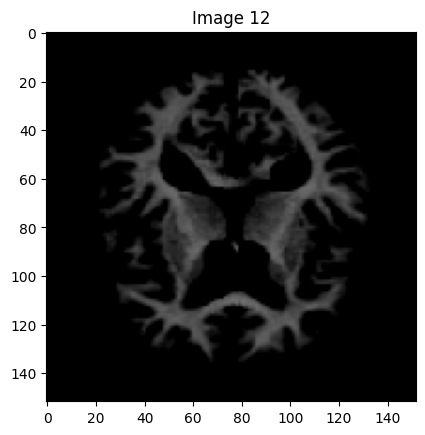

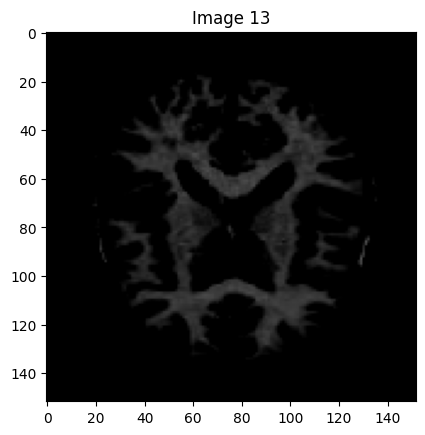

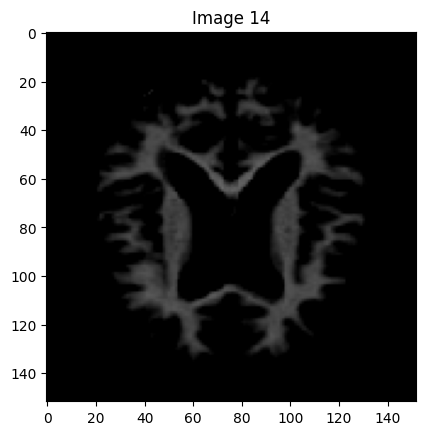

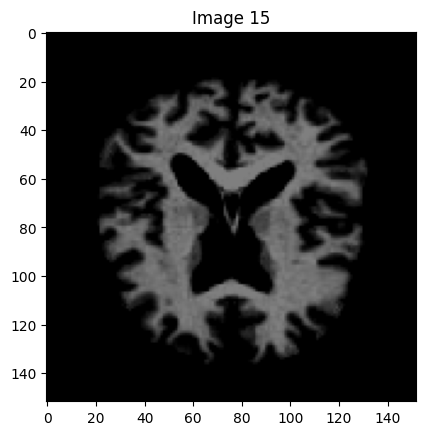

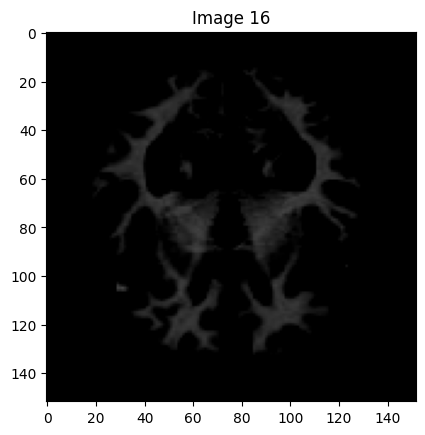

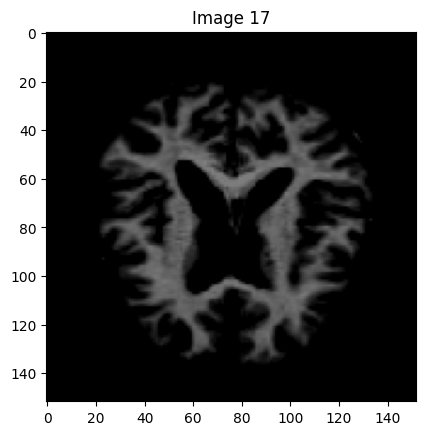

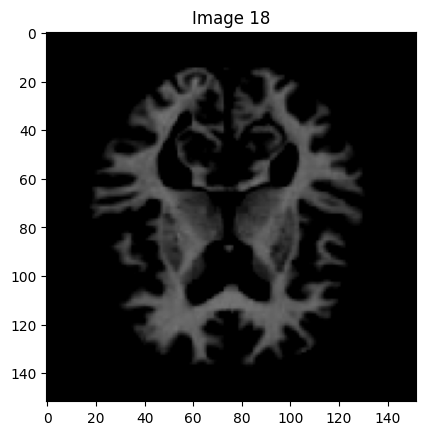

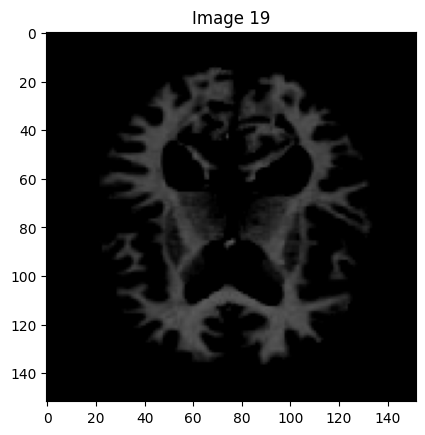

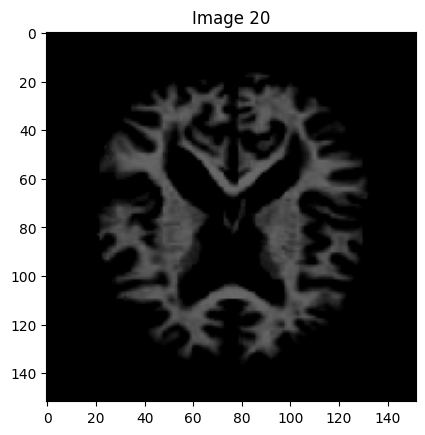

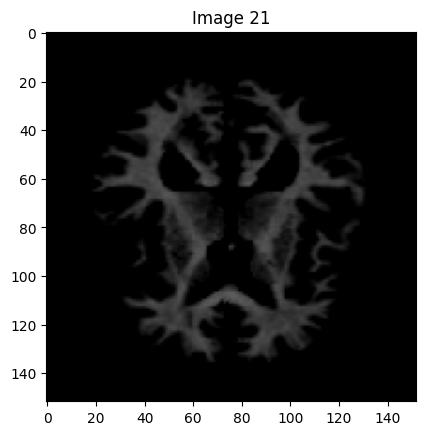

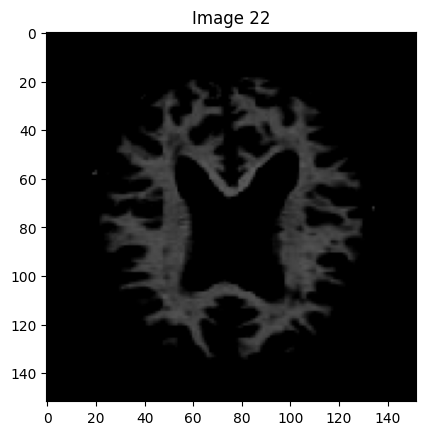

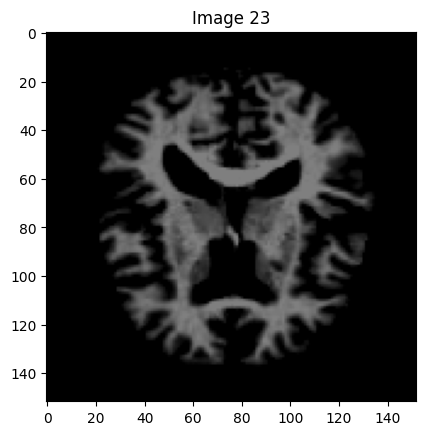

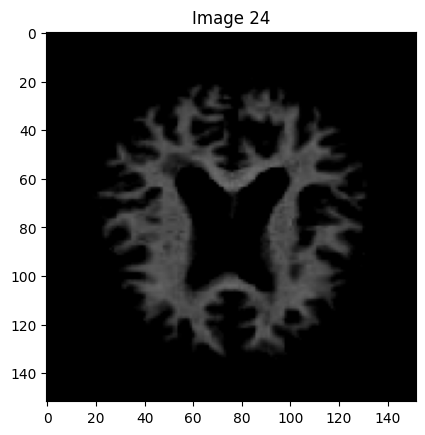

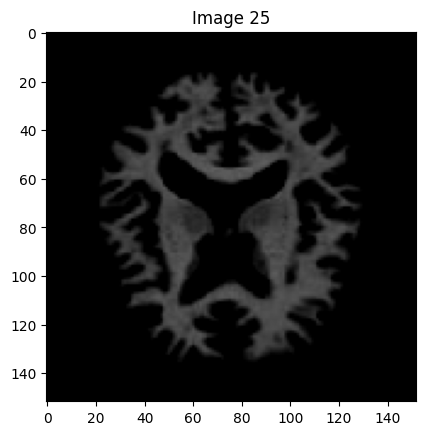

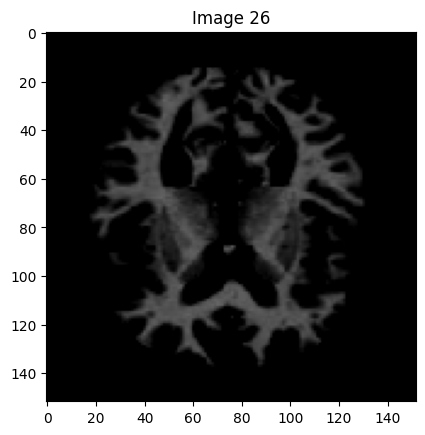

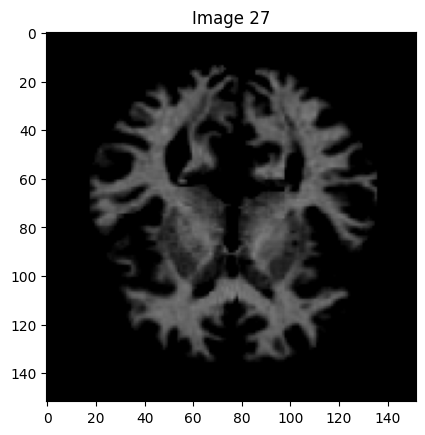

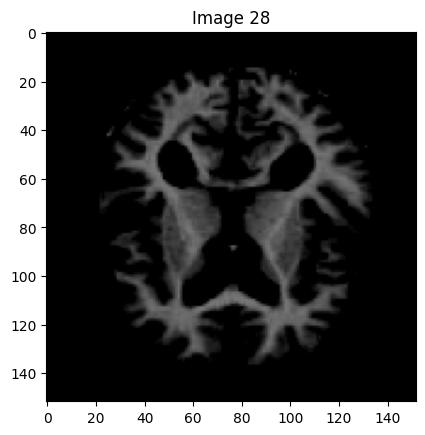

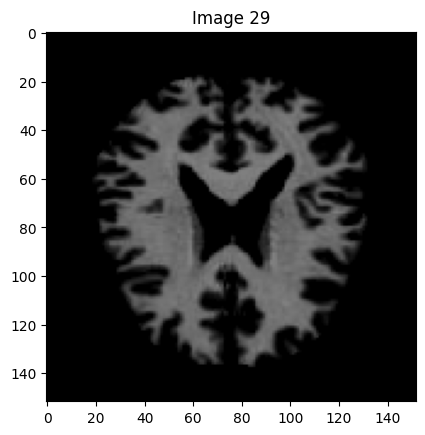

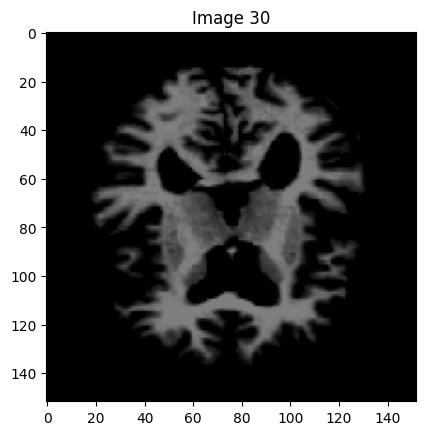

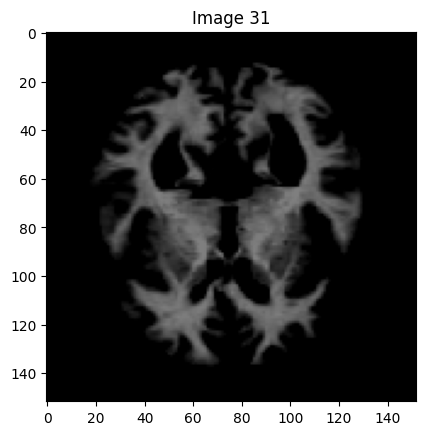

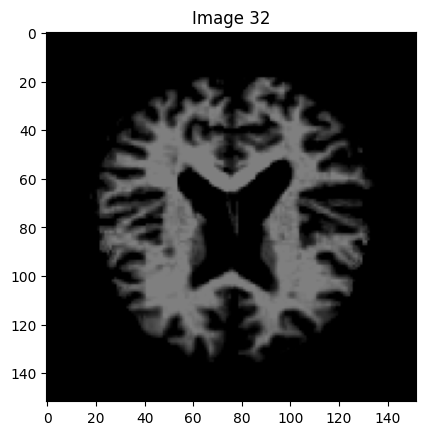

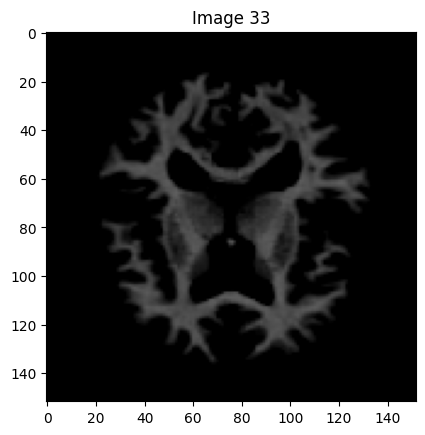

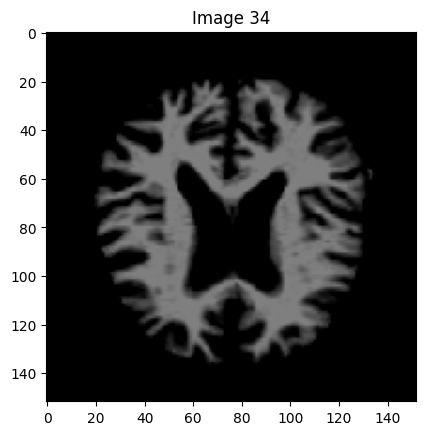

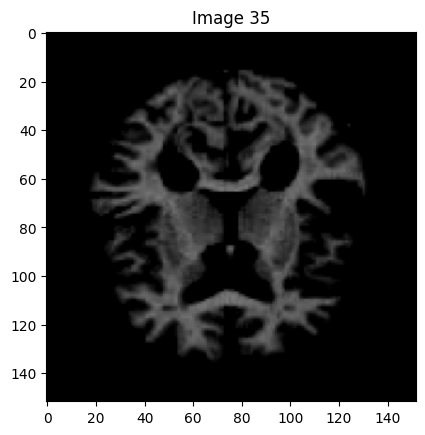

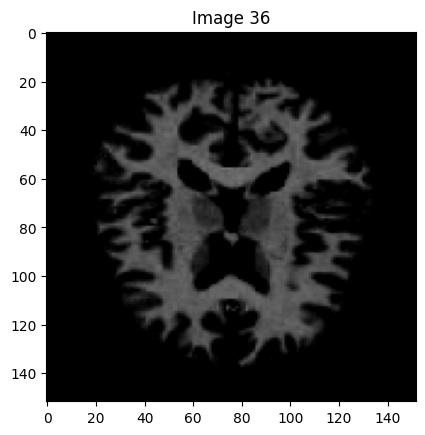

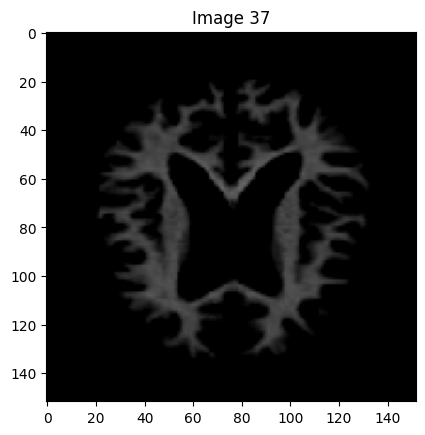

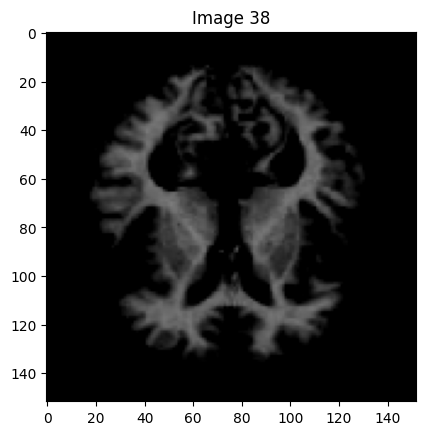

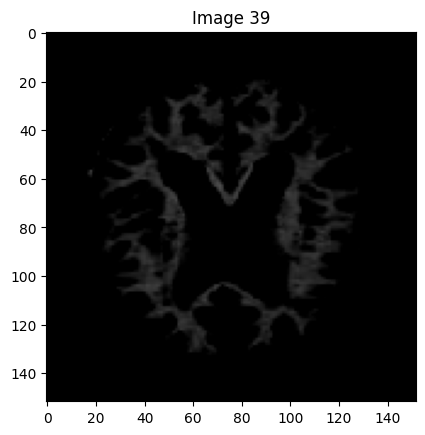

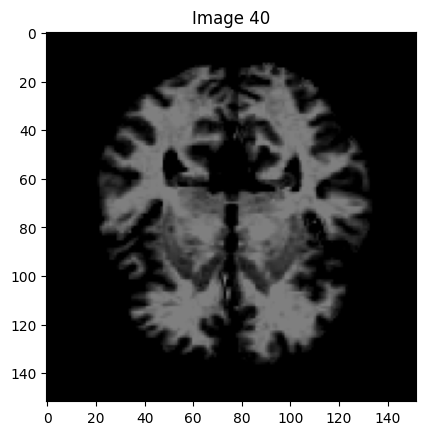

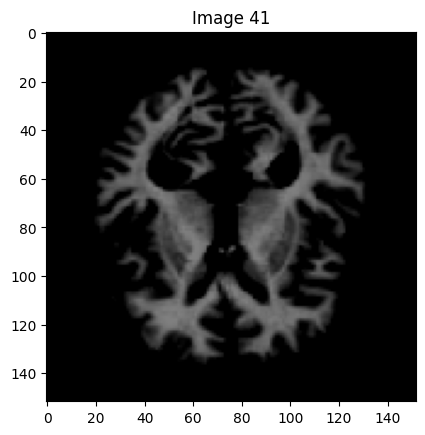

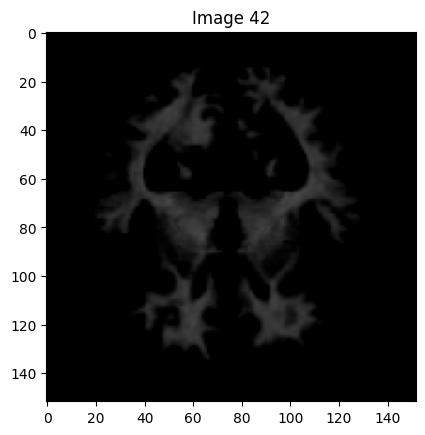

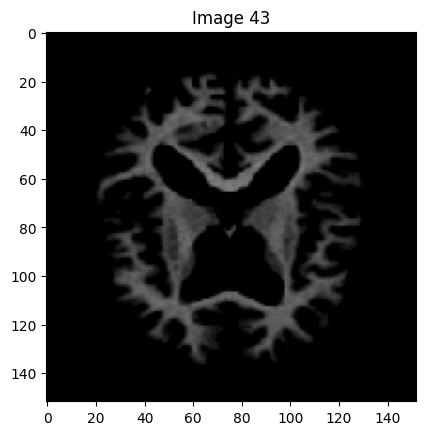

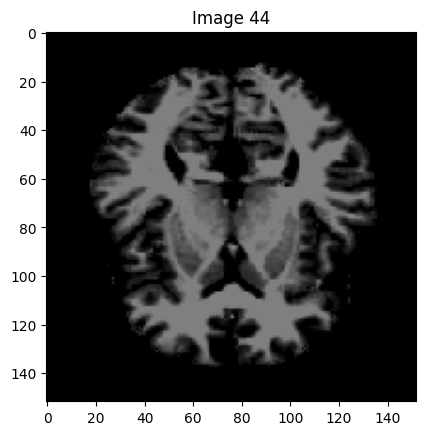

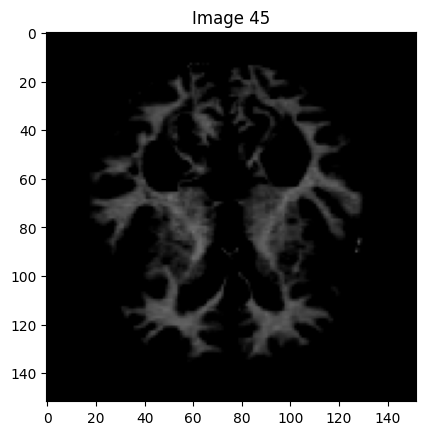

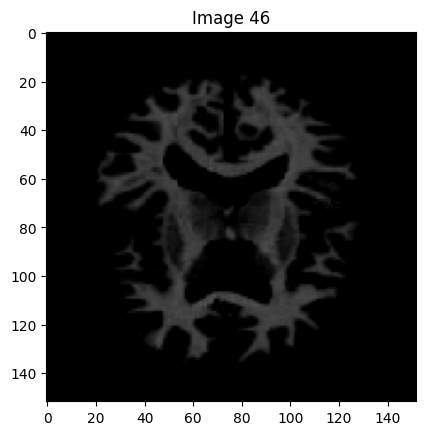

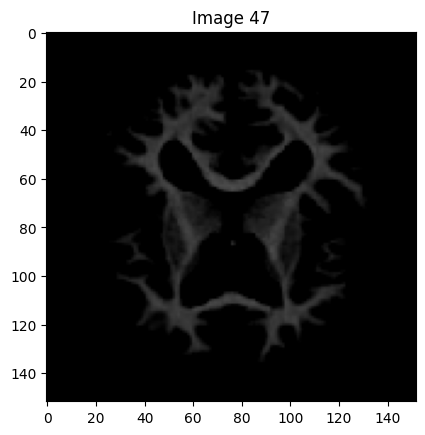

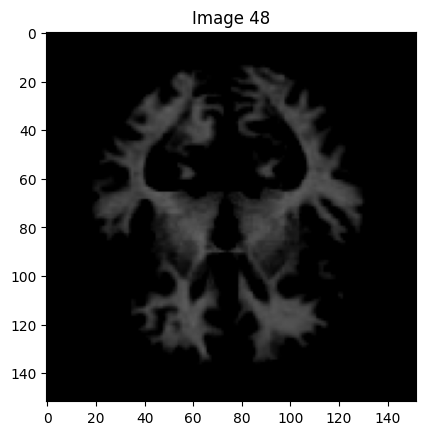

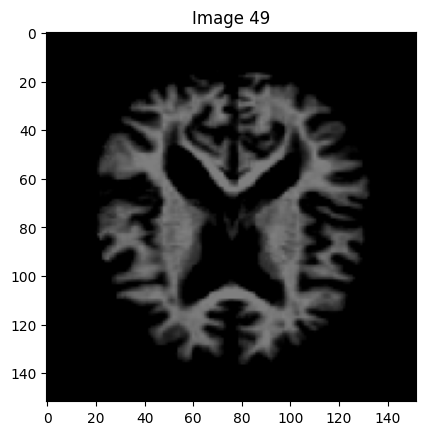

In [ ]:
import matplotlib.pyplot as plt
import os

# Set the directory in Google Drive where you want to save images
save_dir = "/content/drive/My Drive/Courses/DL BU/MRI/mri_images/kaggle"
os.makedirs(save_dir, exist_ok=True)

# Assuming x_test is your MNIST test dataset
# Loop through the first 50 images
for i in range(50):
    # Remove the singleton dimension
    X = x_test[i, :, :, :, 0]

    # If you need to convert to grayscale, use a weighted sum of the RGB channels
    # X_gray = np.dot(X[...,:3], [0.2989, 0.5870, 0.1140])

    # Display the image (use X_gray if you converted to grayscale)
    plt.imshow(X, cmap='gray')
    plt.title(f"Image {i}")
    plt.show()

    # Save the image (use X_gray if you converted to grayscale)
    #plt.imsave(os.path.join(save_dir, f"mri_image_{i}.png"), X, cmap='gray')


In [ ]:
X = x_test[0].reshape((1,) + x_test[0].shape)
plt.imshow(X.reshape(208, 176));

ValueError: ignored

Counterfactual parameters:

In [ ]:
shape = (1,) + x_train.shape[1:]
target_proba = 1.0
tol = 0.01 # want counterfactuals with p(class)>0.99
target_class = 'other' # any class other than 7 will do
max_iter = 1000
lam_init = 1e-1
max_lam_steps = 10
learning_rate_init = 0.1
feature_range = (x_train.min(),x_train.max())

Run counterfactual:

In [ ]:
# initialize explainer
cf = Counterfactual(cnn, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                    max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                    feature_range=feature_range)

start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

1/1 [==============================] - 1s 1s/step


RuntimeError: ignored

Results:

Counterfactual prediction: 3 with probability 0.9965953230857849


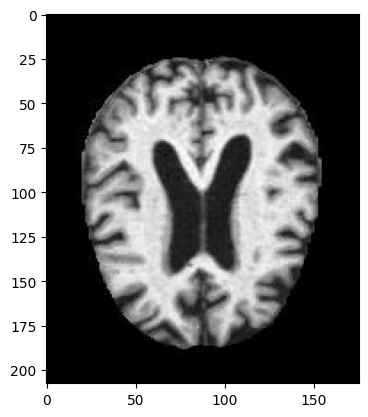

In [ ]:
pred_class = explanation.cf['class']
proba = explanation.cf['proba'][0][pred_class]

print(f'Counterfactual prediction: {pred_class} with probability {proba}')
plt.imshow(explanation.cf['X'].reshape(208, 176));

The counterfactual starting from a 7 moves towards the closest class as determined by the model and the data - in this case a 9. The evolution of the counterfactual during the iterations over $\lambda$ can be seen below (note that all of the following examples satisfy the counterfactual condition):

Explanation for image 0 took 20.147 sec
Counterfactual prediction for image 0: 3 with probability 0.9926336407661438


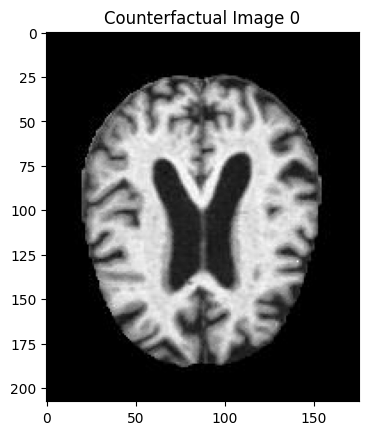

Explanation for image 1 took 82.254 sec
Counterfactual prediction for image 1: 2 with probability 0.9972187280654907


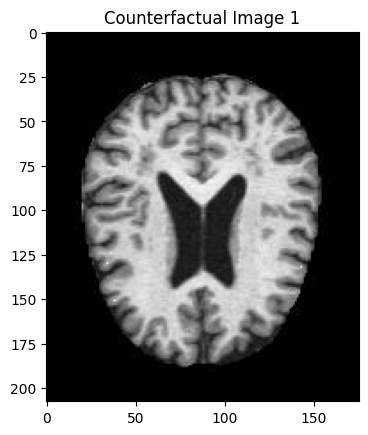

Explanation for image 2 took 62.344 sec
Counterfactual prediction for image 2: 2 with probability 0.9955249428749084


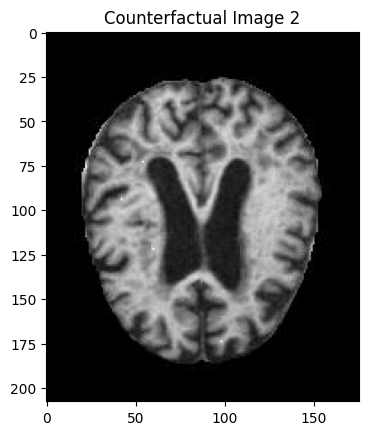

Explanation for image 3 took 24.864 sec
Counterfactual prediction for image 3: 2 with probability 0.9967260360717773


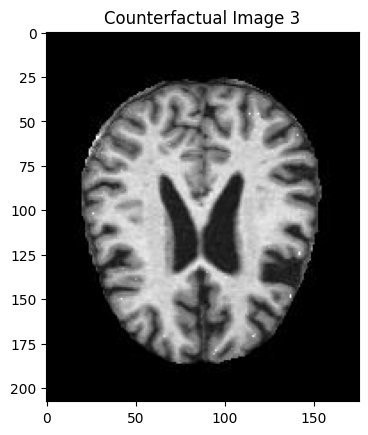

Explanation for image 4 took 71.680 sec
Counterfactual prediction for image 4: 0 with probability 0.990053117275238


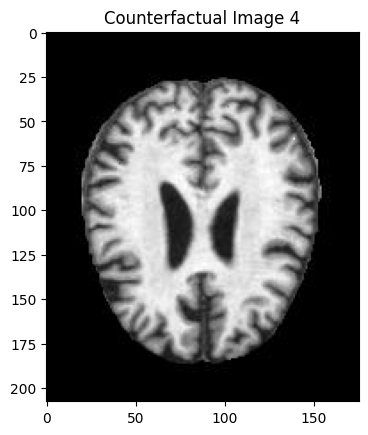

Explanation for image 5 took 59.957 sec
Counterfactual prediction for image 5: 2 with probability 0.9907825589179993


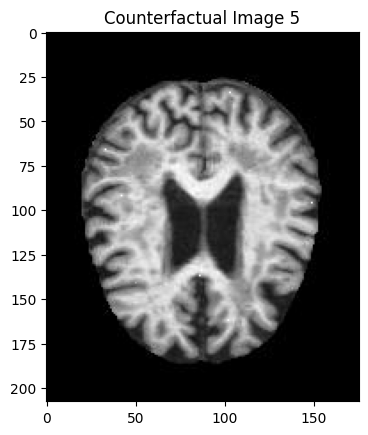

Explanation for image 6 took 17.586 sec
Counterfactual prediction for image 6: 2 with probability 0.9934104084968567


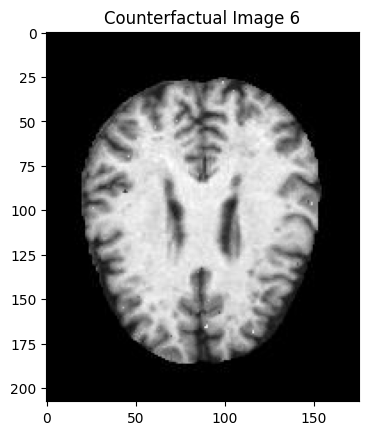

Explanation for image 7 took 17.362 sec
Counterfactual prediction for image 7: 2 with probability 0.9987154006958008


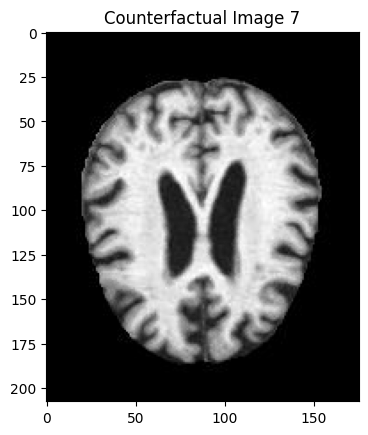

Explanation for image 8 took 69.105 sec
Counterfactual prediction for image 8: 0 with probability 0.9910961389541626


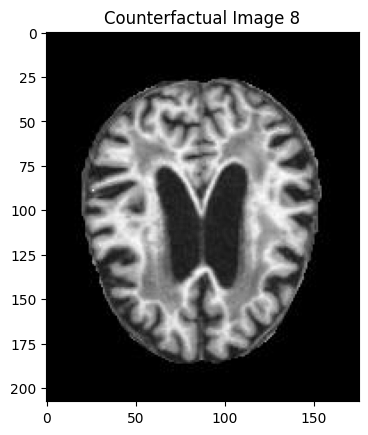

Explanation for image 9 took 74.153 sec
Counterfactual prediction for image 9: 2 with probability 0.9903117418289185


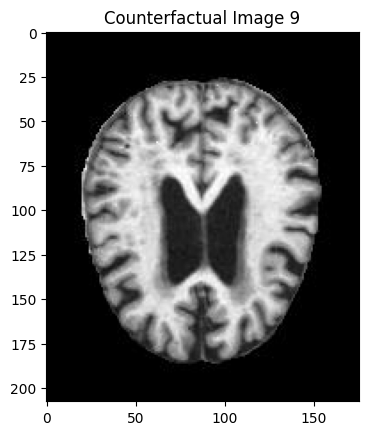

Explanation for image 10 took 49.492 sec
Counterfactual prediction for image 10: 2 with probability 0.9940643906593323


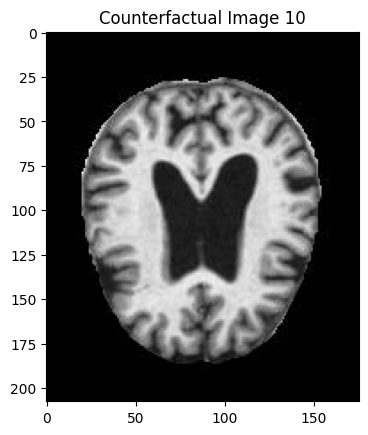

Explanation for image 11 took 58.261 sec
Counterfactual prediction for image 11: 2 with probability 0.9992839694023132


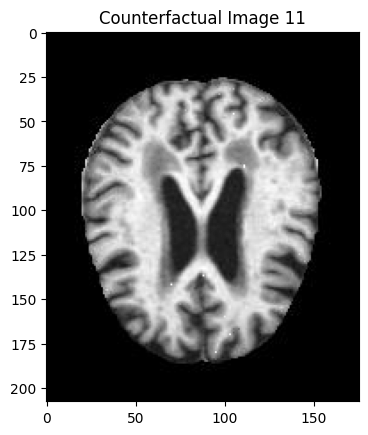

Explanation for image 12 took 28.445 sec
Counterfactual prediction for image 12: 3 with probability 0.9901067614555359


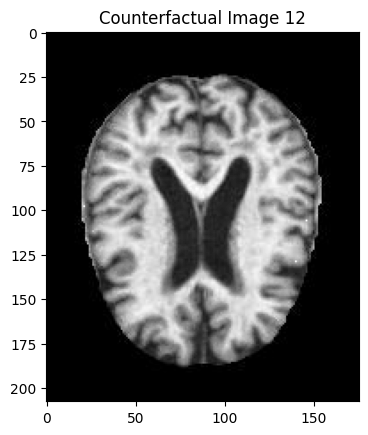

Explanation for image 13 took 24.275 sec
Counterfactual prediction for image 13: 2 with probability 0.9938691854476929


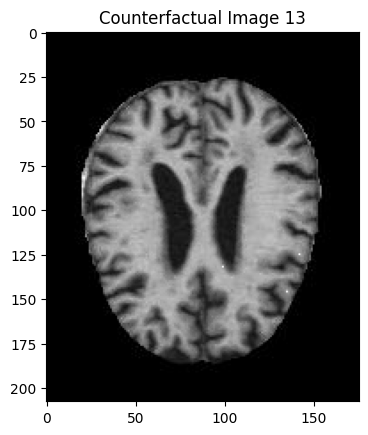

Explanation for image 14 took 31.936 sec
Counterfactual prediction for image 14: 2 with probability 0.9922547340393066


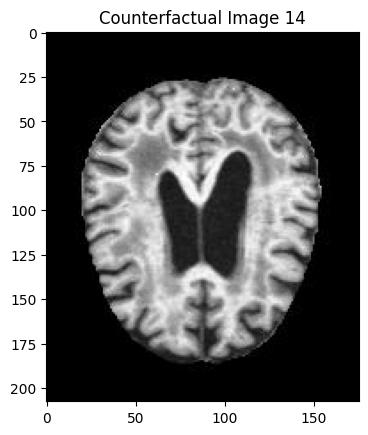

Explanation for image 15 took 31.083 sec
Counterfactual prediction for image 15: 2 with probability 0.9950354099273682


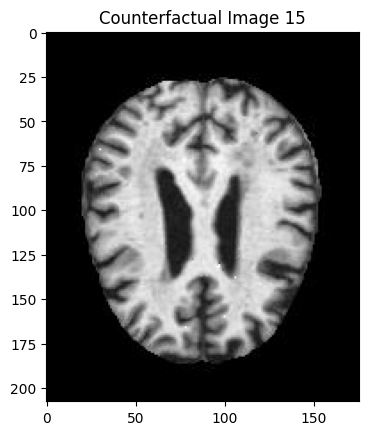

Explanation for image 16 took 38.340 sec
Counterfactual prediction for image 16: 3 with probability 0.9910388588905334


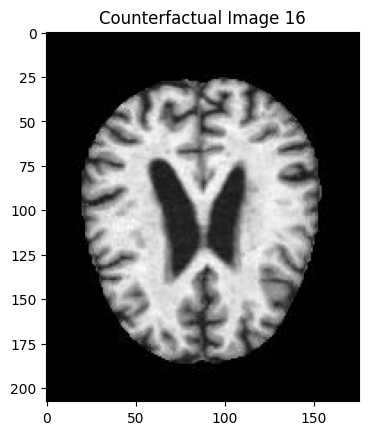

Explanation for image 17 took 20.217 sec
Counterfactual prediction for image 17: 2 with probability 1.0


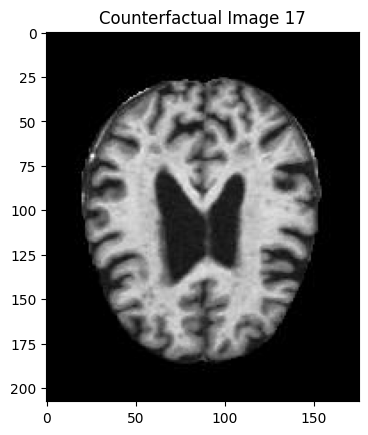

Explanation for image 18 took 77.349 sec
Counterfactual prediction for image 18: 3 with probability 0.9958345890045166


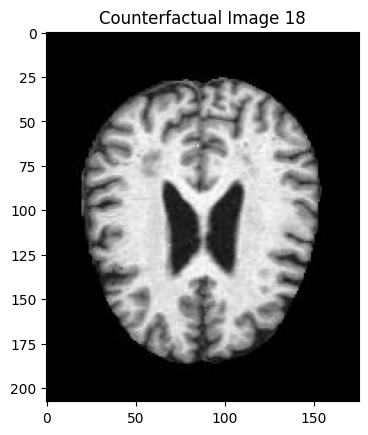

Explanation for image 19 took 55.918 sec
Counterfactual prediction for image 19: 2 with probability 0.9910262227058411


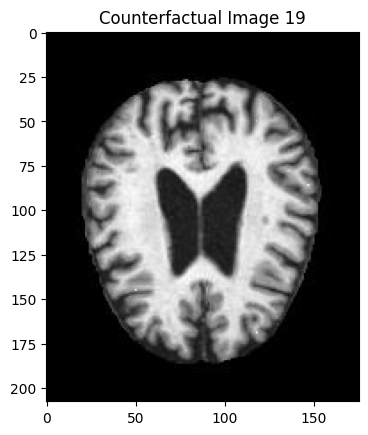

Explanation for image 20 took 47.020 sec
Counterfactual prediction for image 20: 2 with probability 0.9921175837516785


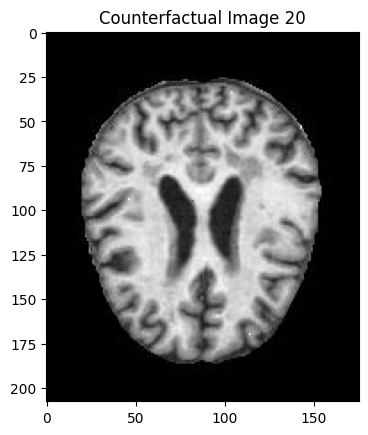

Explanation for image 21 took 74.318 sec
Counterfactual prediction for image 21: 2 with probability 0.9904007315635681


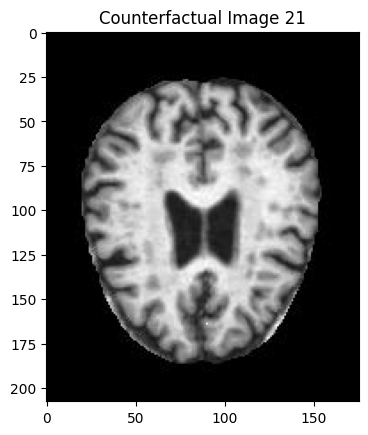

Explanation for image 22 took 56.997 sec
Counterfactual prediction for image 22: 3 with probability 0.9937445521354675


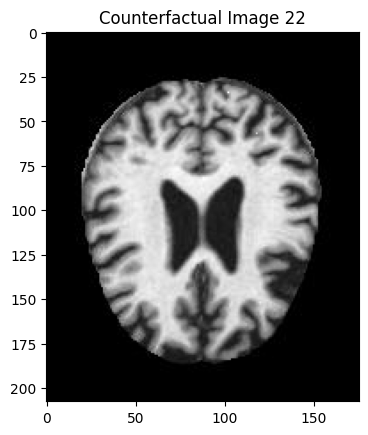

Explanation for image 23 took 23.660 sec
Counterfactual prediction for image 23: 2 with probability 0.99608314037323


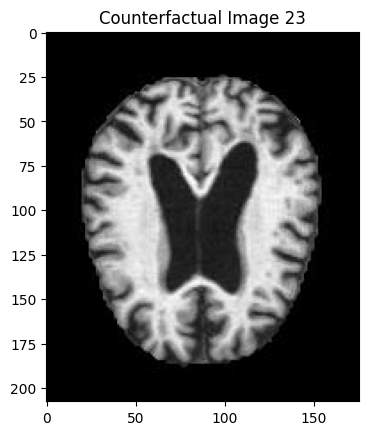

Explanation for image 24 took 38.762 sec
Counterfactual prediction for image 24: 0 with probability 0.9910203814506531


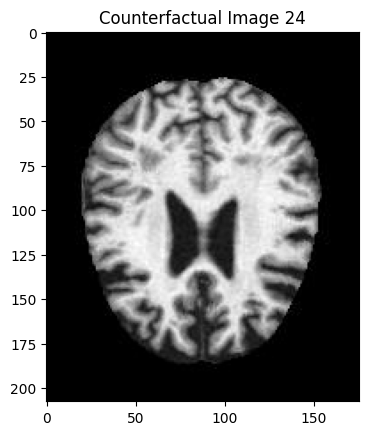

Explanation for image 25 took 39.676 sec
Counterfactual prediction for image 25: 2 with probability 0.9919838309288025


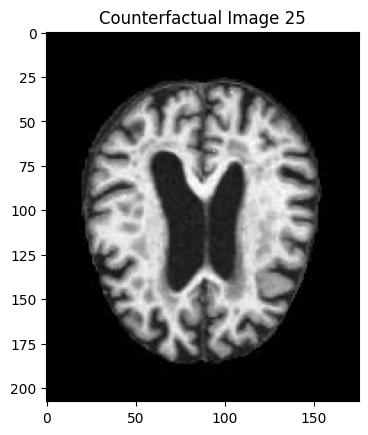

Explanation for image 26 took 50.980 sec
Counterfactual prediction for image 26: 2 with probability 0.9907985925674438


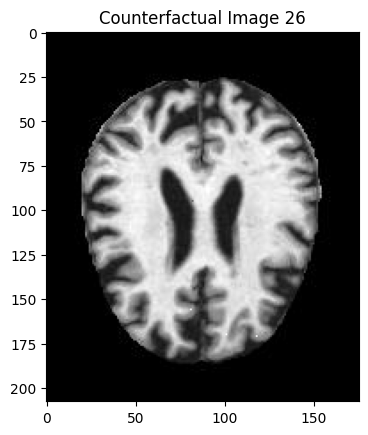

Explanation for image 27 took 63.912 sec
Counterfactual prediction for image 27: 2 with probability 0.9967306852340698


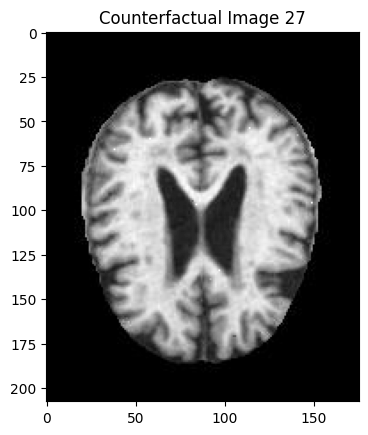

Explanation for image 28 took 21.855 sec
Counterfactual prediction for image 28: 3 with probability 0.9918493032455444


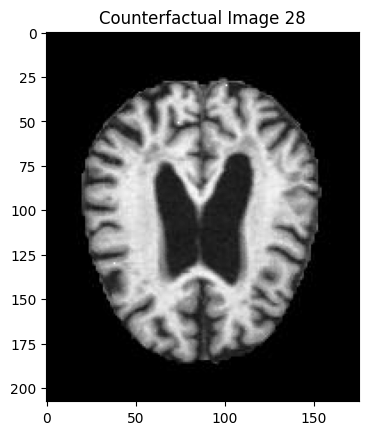

Explanation for image 29 took 67.758 sec
Counterfactual prediction for image 29: 2 with probability 0.9948297142982483


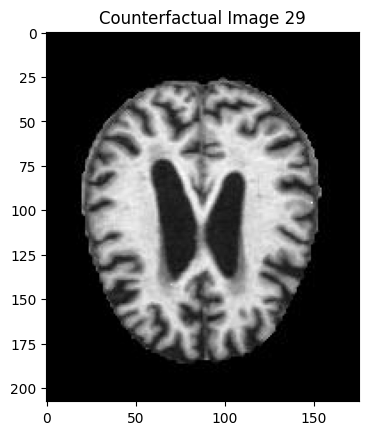

Explanation for image 30 took 25.089 sec
Counterfactual prediction for image 30: 3 with probability 0.9940505623817444


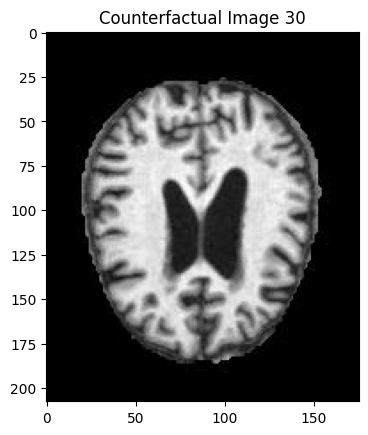

Explanation for image 31 took 21.522 sec
Counterfactual prediction for image 31: 3 with probability 0.9938115477561951


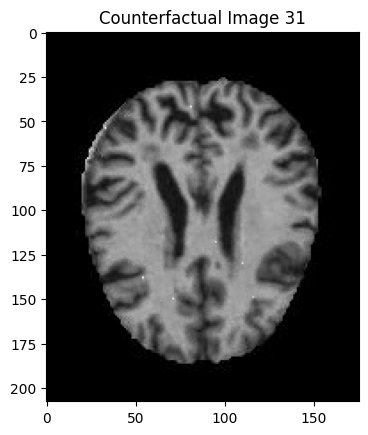

Explanation for image 32 took 67.141 sec
Counterfactual prediction for image 32: 2 with probability 0.9903234243392944


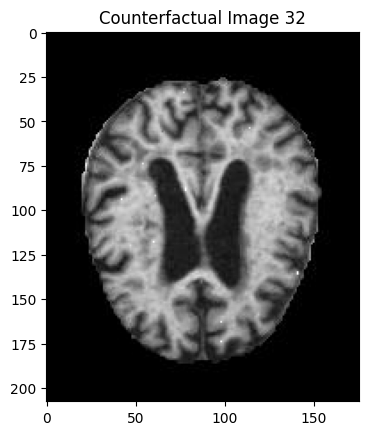

Explanation for image 33 took 35.780 sec
Counterfactual prediction for image 33: 2 with probability 0.9979068040847778


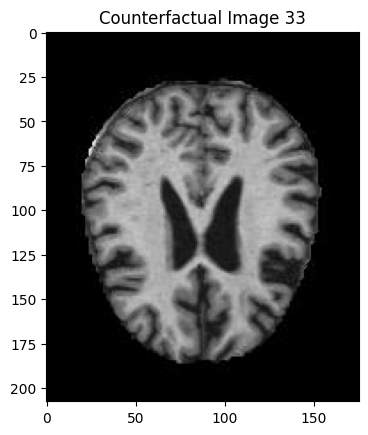

Explanation for image 34 took 69.266 sec
Counterfactual prediction for image 34: 2 with probability 0.9909530878067017


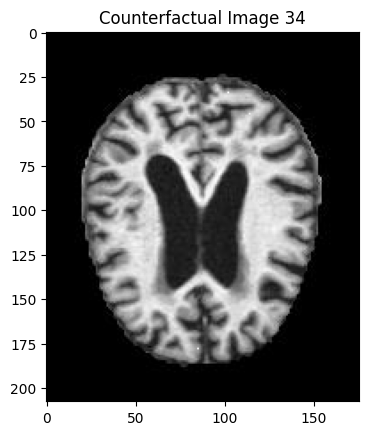

Explanation for image 35 took 23.948 sec
Counterfactual prediction for image 35: 0 with probability 0.9963793158531189


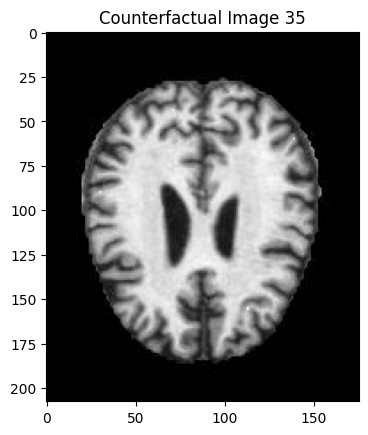

Explanation for image 36 took 76.895 sec
Counterfactual prediction for image 36: 2 with probability 0.9915477633476257


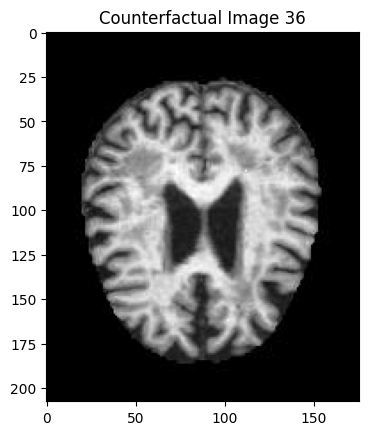

Explanation for image 37 took 25.428 sec
Counterfactual prediction for image 37: 0 with probability 0.9906468391418457


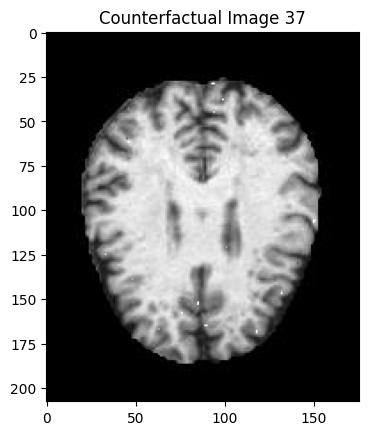

Explanation for image 38 took 22.568 sec
Counterfactual prediction for image 38: 2 with probability 0.9945068955421448


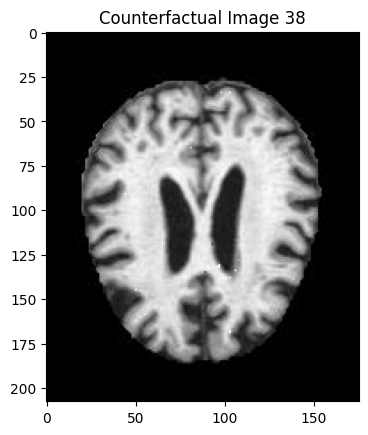

Explanation for image 39 took 78.175 sec
Counterfactual prediction for image 39: 3 with probability 0.9940558671951294


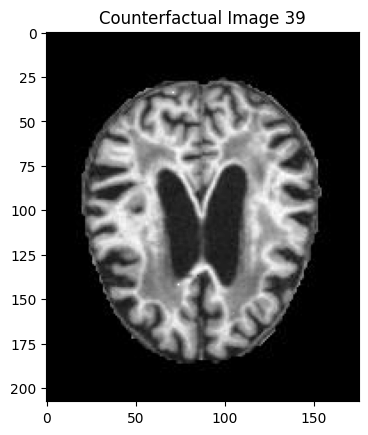

Explanation for image 40 took 62.201 sec
Counterfactual prediction for image 40: 2 with probability 0.9935290217399597


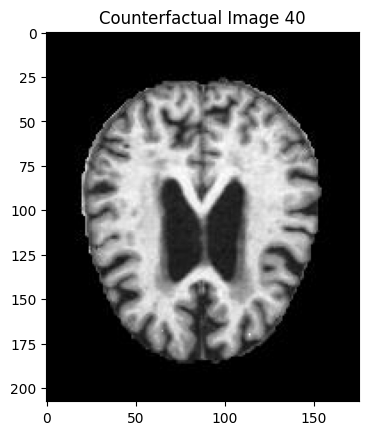

Explanation for image 41 took 61.410 sec
Counterfactual prediction for image 41: 2 with probability 0.9917367100715637


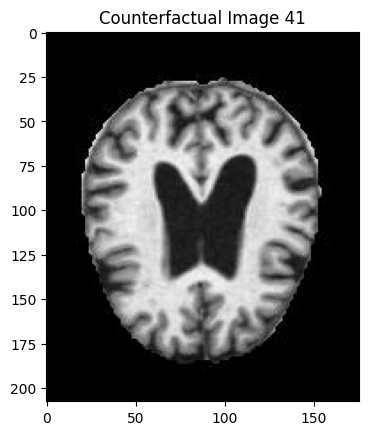

Explanation for image 42 took 22.726 sec
Counterfactual prediction for image 42: 2 with probability 0.9995545744895935


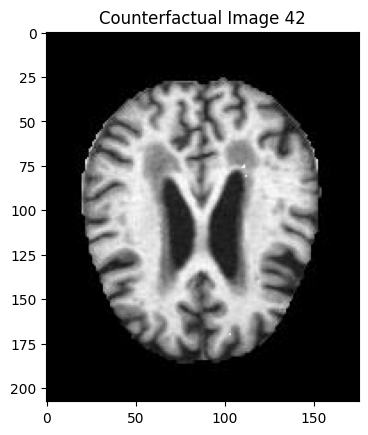

Explanation for image 43 took 28.246 sec
Counterfactual prediction for image 43: 2 with probability 0.9927608966827393


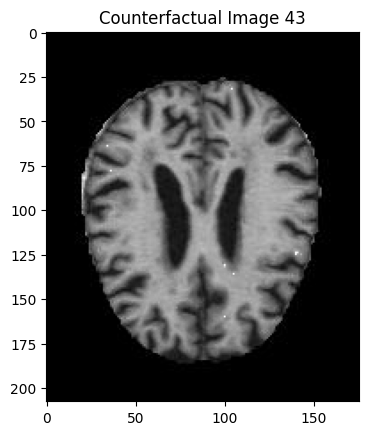

Explanation for image 44 took 23.782 sec
Counterfactual prediction for image 44: 3 with probability 0.9904272556304932


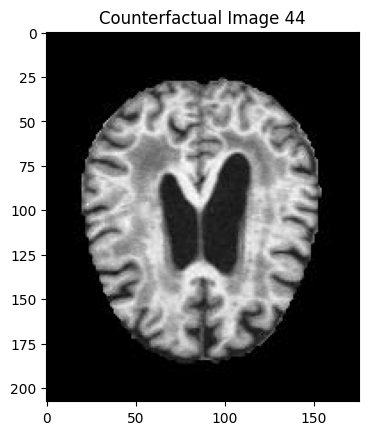

Explanation for image 45 took 76.191 sec
Counterfactual prediction for image 45: 2 with probability 0.9988497495651245


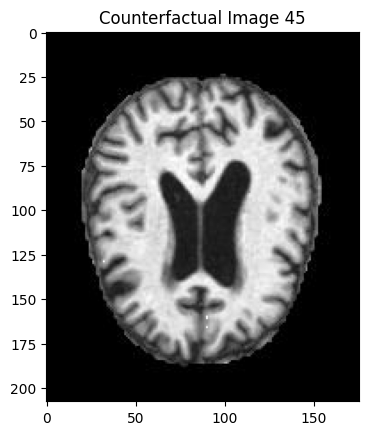

Explanation for image 46 took 84.008 sec
Counterfactual prediction for image 46: 0 with probability 0.9923285841941833


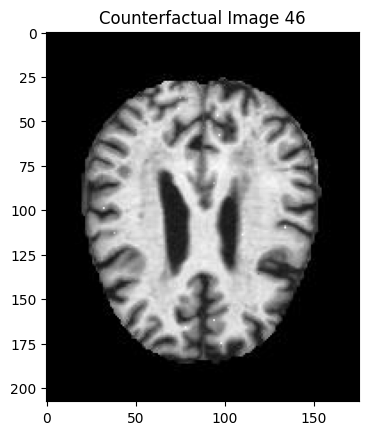

Explanation for image 47 took 48.277 sec
Counterfactual prediction for image 47: 2 with probability 0.9960049986839294


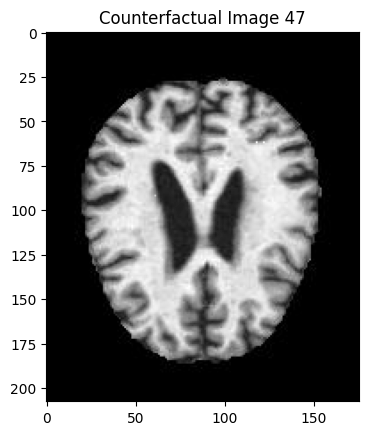

Explanation for image 48 took 32.040 sec
Counterfactual prediction for image 48: 2 with probability 0.9992606043815613


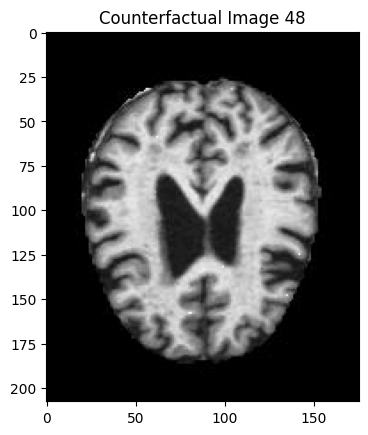

Explanation for image 49 took 42.909 sec
Counterfactual prediction for image 49: 3 with probability 0.991232693195343


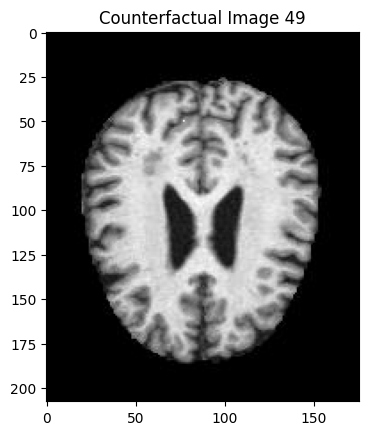

Explanation for image 50 took 87.479 sec
Counterfactual prediction for image 50: 2 with probability 0.992362380027771


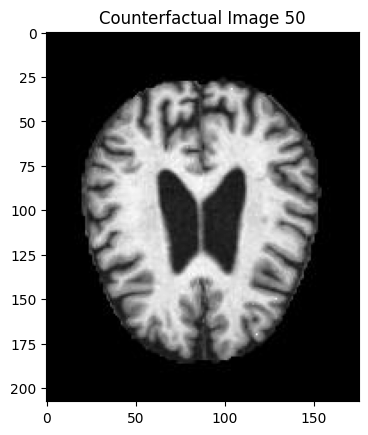

Explanation for image 51 took 55.065 sec
Counterfactual prediction for image 51: 2 with probability 0.9957948923110962


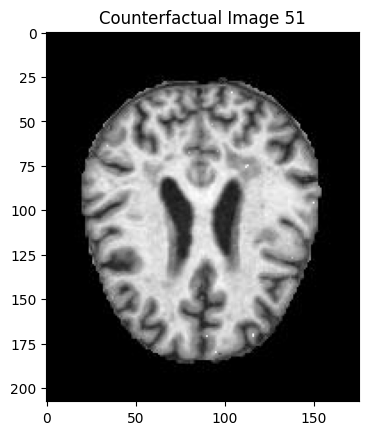

Explanation for image 52 took 45.632 sec
Counterfactual prediction for image 52: 0 with probability 0.9907230734825134


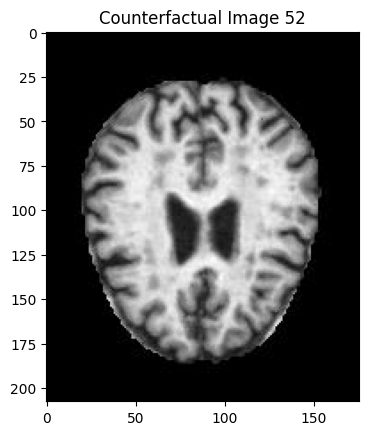

Explanation for image 53 took 24.115 sec
Counterfactual prediction for image 53: 0 with probability 0.9920599460601807


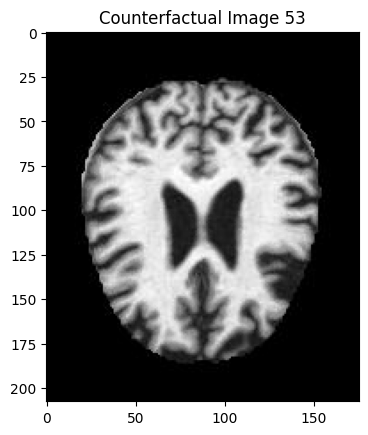

Explanation for image 54 took 36.858 sec
Counterfactual prediction for image 54: 0 with probability 0.9959548711776733


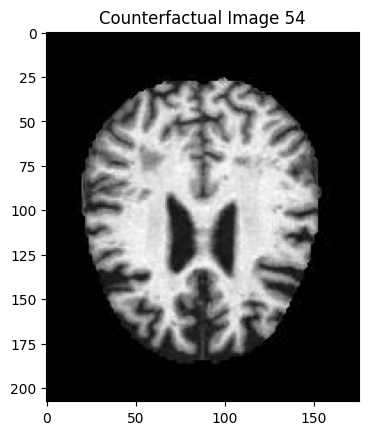

KeyboardInterrupt: ignored

In [ ]:
import csv
from time import time
import matplotlib.pyplot as plt
import os

# Assuming cf is your initialized Counterfactual explainer
# Assuming x_train is your MNIST train dataset
csv_data = []

# Set the directory where you want to save counterfactual images
save_dir = "/content/drive/My Drive/Courses/DL BU/MRI/counterfactual_images"
os.makedirs(save_dir, exist_ok=True)

# Loop through the desired number of images
for i in range(len(x_train)):
    X = x_test[i].reshape((1,) + x_test[i].shape)

    start_time = time()
    explanation = cf.explain(X)
    elapsed_time = time() - start_time
    print('Explanation for image {} took {:.3f} sec'.format(i, time() - start_time))

    if explanation.cf is not None:
        pred_class = explanation.cf['class']
        proba = explanation.cf['proba'][0][pred_class]

        print(f'Counterfactual prediction for image {i}: {pred_class} with probability {proba}')

        # Append data to CSV list
        csv_data.append([i, pred_class, proba, elapsed_time])

        plt.imshow(explanation.cf['X'].reshape(208, 176))
        plt.title(f"Counterfactual Image {i}")
        plt.show()

        plt.imsave(os.path.join(save_dir, f"counterfactual_image_{i}.png"), explanation.cf['X'].reshape(208, 176), cmap='gray')


        # Display and/or save the counterfactual image as before...
    else:
        print(f"No valid counterfactual explanation for image {i}")
        # You can choose to append a different set of data for invalid cases
        csv_data.append([i, 'No valid explanation', 0, elapsed_time])


    # Display the counterfactual image


    # Save the counterfactual image


csv_file_path = '/content/drive/My Drive/Courses/DL BU/MRI/counterfactuals.csv'
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Index', 'Predicted Class', 'Probability', 'Time Taken (sec)'])
    writer.writerows(csv_data)

print(f"CSV file saved at {csv_file_path}")